In [1]:
# 2022/05/25 업데이트 내용:
# 경기도, 인천 포함

In [2]:
import pandas as pd
import numpy as np
import os
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
pd.options.mode.chained_assignment = None  # default='warn'
plt.rcParams['font.family'] = 'Malgun Gothic'
import datetime
tqdm.tqdm.pandas()

In [3]:
target_sido = '서울' # 시도 명: 서울, 인천, 경기 중 하나 선택
target_gu = '광진구' # 구 명
target_dong = '능' # 동 명: 동 명에서 마지막 글자 '동' 뺄 것.
target_ri = '' # 리 명
#target_purpose = '준주거' # 종 명: 건드릴 필요 없음
target_building_age = 5 # 건물연식: 건드릴 필요 없음
target_period = 36 # 계약날짜 검색범위: 건드릴 필요 없음
target_starting_year = 2018 # 검색 시작 계약 년도: 건드릴 필요 없음

In [4]:
date_today = pd.to_datetime(datetime.datetime.now().strftime('%Y-%m-%d'), format='%Y-%m-%d')

In [5]:
date_today_record = str(date_today).split(' ')[0].replace('-', '')
date_today_record

'20220616'

In [6]:
def day_modifier(x):
    # x is a number
    
    if pd.isna(x) == True:
        return x
    else:
        x = str(x)
        if len(x) == 1:
            return '0' + x
        else:
            return x

In [7]:
def landnum_modifier(x):
    # x is a string
    
    if pd.isna(x) == True:
        return x
    else:
        x = str(x).replace('외', '').replace(' ','')
        splitted = x.split('-')
        if len(splitted) == 1:
            return x + '-0'
        else:
            return x

In [8]:
def data_prep(bdtype, tradetype, starting_year=2018, sido=target_sido):
    # bdtype is a string: one of 아파트, 연립다세대 or 오피스텔
    # tradetype is a string: one of 매매 or 전월세
    if (tradetype != '매매') & (tradetype != '전월세'):
        raise ValueError('두번째 변수는 매매 또는 전월세만 입력 가능')
    
    if sido == '서울':
        basedir = './국토교통부_실거래가_공개시스템/{}/{}/'.format(bdtype, tradetype)
    elif sido == '인천':
        basedir = './국토교통부_실거래가_공개시스템/인천/{}/{}/'.format(bdtype, tradetype)
    elif sido == '경기':
        basedir = './국토교통부_실거래가_공개시스템/경기도/{}/{}/'.format(bdtype, tradetype)
    
    filenames = [f for f in os.listdir(basedir) if (f.endswith('.csv'))&('(' in f)]
    
    dfs_list = []
    for i, f in tqdm.tqdm_notebook(enumerate(filenames)):
        splitted_filename = f.split('실거래가_')       
        file_year = int(splitted_filename[-1][:4])
        
        if file_year <= starting_year:
            continue
        
        try:
            df = pd.read_csv(basedir + f, encoding='euc-kr', header=15)
        except:
            try:
                df = pd.read_csv(basedir + f, encoding='utf-8', header=15)
            except:
                df = pd.read_csv(basedir + f, header=15)
        
        if '건물명' in df.columns:
            df.rename(columns={'건물명':'건물(단지)명'}, inplace=True)
        elif '단지명' in df.columns:
            df.rename(columns={'단지명':'건물(단지)명'}, inplace=True)
            
        if '대지권면적(㎡)' in df.columns:
            df = df.drop(columns=['대지권면적(㎡)'])
                
            
        if '해제사유발생일' in df.columns.tolist():
            df = df[df['해제사유발생일'].isna()]
            df = df.drop(columns=['해제사유발생일'])
            
        dfs_list.append(df)
    
    concat_df = pd.concat(dfs_list).reset_index(drop=True)
    
    if tradetype == '전월세':
        concat_df = concat_df.rename(columns={'전월세구분':'거래구분', '보증금(만원)':'거래금액(만원)'})
        concat_df = concat_df.drop(columns=['월세(만원)'])
        concat_df = concat_df[concat_df['거래구분'] == '전세']
    elif tradetype == '매매':
        concat_df['거래구분'] = '매매'
        
    concat_df['번지'] = concat_df['번지'].apply(landnum_modifier)
    
    concat_df['계약년월'] = concat_df['계약년월'].astype('Int64')
    concat_df['계약일'] = concat_df['계약일'].astype('Int64')
    
    concat_df['계약년월'] = concat_df['계약년월'].apply(str)
    concat_df['계약일'] = concat_df['계약일'].apply(str)
    
    concat_df['계약날짜기준_건물연식'] = concat_df['계약년월'].apply(lambda x: int(x[:4])) - concat_df['건축년도']
    
    concat_df['계약일'] = concat_df['계약일'].apply(day_modifier)
    
    concat_df['계약날짜'] = concat_df['계약년월'].apply(lambda x: x[:4]) + '-' + concat_df['계약년월'].apply(lambda x: x[-2:])\
    + '-' + concat_df['계약일']
    
    concat_df['계약날짜'] = pd.to_datetime(concat_df['계약날짜'], format='%Y-%m-%d')
    
    concat_df['거래금액(만원)'] = concat_df['거래금액(만원)'].apply(lambda x: int(x.replace(',','')))
    concat_df['단가(만원/㎡)'] = concat_df['거래금액(만원)'] / concat_df['전용면적(㎡)']
    
    concat_df['지번주소'] = concat_df['시군구'] + ' ' + concat_df['번지']
        
    cols_to_drop = ['번지', '지번주소', '계약년월', '계약일', '도로명']
        
    concat_df = concat_df[['지번주소', '도로명'] + [col for col in concat_df.columns if col not in cols_to_drop]]
    
    date_today = pd.to_datetime(datetime.datetime.now().strftime('%Y-%m-%d'), format='%Y-%m-%d')
    concat_df['건물연식'] = date_today.year - concat_df['건축년도']
    
    concat_df = concat_df.dropna(subset=['지번주소'])
    
    concat_df = concat_df[concat_df['층'] >= 0].reset_index(drop=True)
    
    return concat_df

In [9]:
apart_trade_df = data_prep('아파트', '매매')
apart_lease_df = data_prep('아파트', '전월세')
apart_df = pd.concat([apart_trade_df, apart_lease_df]).reset_index(drop=True)
del apart_trade_df, apart_lease_df
apart_df['부동산유형'] = '아파트'
print(apart_df.shape)
apart_df.head()

c:\users\max6296\ml\lib\site-packages\ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


0it [00:00, ?it/s]

0it [00:00, ?it/s]

c:\users\max6296\ml\lib\site-packages\ipykernel_launcher.py:2: DtypeWarning: Columns (10,18) have mixed types.Specify dtype option on import or set low_memory=False.
  
c:\users\max6296\ml\lib\site-packages\ipykernel_launcher.py:2: DtypeWarning: Columns (18) have mixed types.Specify dtype option on import or set low_memory=False.
  


(647845, 23)


,지번주소,도로명,시군구,본번,부번,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,거래유형,중개사소재지,거래구분,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,계약기간,계약구분,갱신요구권 사용,종전계약 보증금 (만원),종전계약 월세 (만원),부동산유형
0,서울특별시 강남구 개포동 655-2,언주로 103,서울특별시 강남구 개포동,655.0,2.0,개포2차현대아파트(220),77.75,134500,4,1988.0,-,-,매매,31.0,2019-06-18,1729.903537,34.0,NaN,NaN,NaN,NaN,NaN,아파트
1,서울특별시 강남구 개포동 655-2,언주로 103,서울특별시 강남구 개포동,655.0,2.0,개포2차현대아파트(220),77.75,160000,2,1988.0,-,-,매매,31.0,2019-11-18,2057.877814,34.0,NaN,NaN,NaN,NaN,NaN,아파트
2,서울특별시 강남구 개포동 658-1,언주로 3,서울특별시 강남구 개포동,658.0,1.0,개포6차우성아파트1동~8동,67.28,124000,4,1987.0,-,-,매매,32.0,2019-05-04,1843.043995,35.0,NaN,NaN,NaN,NaN,NaN,아파트
3,서울특별시 강남구 개포동 658-1,언주로 3,서울특별시 강남구 개포동,658.0,1.0,개포6차우성아파트1동~8동,79.97,141000,5,1987.0,-,-,매매,32.0,2019-06-15,1763.161185,35.0,NaN,NaN,NaN,NaN,NaN,아파트
4,서울특별시 강남구 개포동 658-1,언주로 3,서울특별시 강남구 개포동,658.0,1.0,개포6차우성아파트1동~8동,79.97,155000,4,1987.0,-,-,매매,32.0,2019-08-28,1938.226835,35.0,NaN,NaN,NaN,NaN,NaN,아파트


In [10]:
yunrip_trade_df = data_prep('연립다세대', '매매')
yunrip_lease_df = data_prep('연립다세대', '전월세')
yunrip_df = pd.concat([yunrip_trade_df, yunrip_lease_df]).reset_index(drop=True)
del yunrip_trade_df, yunrip_lease_df
yunrip_df['부동산유형'] = '연립다세대'
print(yunrip_df.shape)
yunrip_df.head()

c:\users\max6296\ml\lib\site-packages\ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


0it [00:00, ?it/s]

0it [00:00, ?it/s]

c:\users\max6296\ml\lib\site-packages\ipykernel_launcher.py:2: DtypeWarning: Columns (10,18) have mixed types.Specify dtype option on import or set low_memory=False.
  


(416492, 23)


,지번주소,도로명,시군구,본번,부번,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,거래유형,중개사소재지,거래구분,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,계약기간,계약구분,갱신요구권 사용,종전계약 보증금 (만원),종전계약 월세 (만원),부동산유형
0,서울특별시 강남구 개포동 1164-27,논현로2길 66,서울특별시 강남구 개포동,1164,27,(1164-27),51.78,55000,3,2016.0,-,-,매매,3.0,2019-02-26,1062.186172,6.0,NaN,NaN,NaN,NaN,NaN,연립다세대
1,서울특별시 강남구 개포동 1164-27,논현로2길 66,서울특별시 강남구 개포동,1164,27,(1164-27),51.78,57500,4,2016.0,-,-,매매,3.0,2019-12-21,1110.467362,6.0,NaN,NaN,NaN,NaN,NaN,연립다세대
2,서울특별시 강남구 개포동 1216-4,개포로26길 16,서울특별시 강남구 개포동,1216,4,(1216-4),33.77,27500,4,2012.0,-,-,매매,7.0,2019-10-26,814.332248,10.0,NaN,NaN,NaN,NaN,NaN,연립다세대
3,서울특별시 강남구 개포동 170-18,선릉로12길 17,서울특별시 강남구 개포동,170,18,(170-18),26.60,38000,1,1988.0,-,-,매매,31.0,2019-03-18,1428.571429,34.0,NaN,NaN,NaN,NaN,NaN,연립다세대
4,서울특별시 강남구 개포동 171-10,선릉로14길 19,서울특별시 강남구 개포동,171,10,(171-10),78.14,68000,2,1991.0,-,-,매매,28.0,2019-02-19,870.232915,31.0,NaN,NaN,NaN,NaN,NaN,연립다세대


In [11]:
officetel_trade_df = data_prep('오피스텔', '매매')
officetel_lease_df = data_prep('오피스텔', '전월세')
officetel_df = pd.concat([officetel_trade_df, officetel_lease_df]).reset_index(drop=True)
del officetel_trade_df, officetel_lease_df
officetel_df['부동산유형'] = '오피스텔'
print(officetel_df.shape)
officetel_df.head()

c:\users\max6296\ml\lib\site-packages\ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


0it [00:00, ?it/s]

0it [00:00, ?it/s]

c:\users\max6296\ml\lib\site-packages\ipykernel_launcher.py:2: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  
c:\users\max6296\ml\lib\site-packages\ipykernel_launcher.py:2: DtypeWarning: Columns (18) have mixed types.Specify dtype option on import or set low_memory=False.
  


(141825, 23)


,지번주소,도로명,시군구,본번,부번,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,거래유형,중개사소재지,거래구분,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,계약기간,계약구분,갱신요구권 사용,종전계약 보증금 (만원),종전계약 월세 (만원),부동산유형
0,서울특별시 강남구 개포동 13-3,개포로 623,서울특별시 강남구 개포동,13,3,대청타워,31.91,22000,12,1997.0,-,-,매매,22.0,2019-01-12,689.439047,25.0,NaN,NaN,NaN,NaN,NaN,오피스텔
1,서울특별시 강남구 개포동 13-3,개포로 623,서울특별시 강남구 개포동,13,3,대청타워,32.44,23500,21,1997.0,-,-,매매,22.0,2019-01-17,724.414303,25.0,NaN,NaN,NaN,NaN,NaN,오피스텔
2,서울특별시 강남구 개포동 13-3,개포로 623,서울특별시 강남구 개포동,13,3,대청타워,31.91,22500,23,1997.0,-,-,매매,22.0,2019-02-22,705.108117,25.0,NaN,NaN,NaN,NaN,NaN,오피스텔
3,서울특별시 강남구 개포동 13-3,개포로 623,서울특별시 강남구 개포동,13,3,대청타워,32.44,20000,21,1997.0,-,-,매매,22.0,2019-03-14,616.522811,25.0,NaN,NaN,NaN,NaN,NaN,오피스텔
4,서울특별시 강남구 개포동 13-3,개포로 623,서울특별시 강남구 개포동,13,3,대청타워,31.91,19900,14,1997.0,-,-,매매,22.0,2019-03-29,623.628956,25.0,NaN,NaN,NaN,NaN,NaN,오피스텔


In [12]:
house_df = pd.concat([apart_df, yunrip_df, officetel_df]).sort_values(['시군구', '본번', '부번', '건축년도', '전용면적(㎡)', '계약날짜']).reset_index(drop=True)
del apart_df, yunrip_df, officetel_df
print(house_df.shape)
house_df.head()

(1206162, 23)


,지번주소,도로명,시군구,본번,부번,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,거래유형,중개사소재지,거래구분,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,계약기간,계약구분,갱신요구권 사용,종전계약 보증금 (만원),종전계약 월세 (만원),부동산유형
0,서울특별시 강남구 개포동 12-0,개포로109길 9,서울특별시 강남구 개포동,12.0,0.0,성원대치2단지아파트,33.18,24000,7,1992.0,NaN,NaN,전세,27.0,2019-01-04,723.327306,30.0,NaN,NaN,NaN,NaN,NaN,아파트
1,서울특별시 강남구 개포동 12-0,개포로109길 9,서울특별시 강남구 개포동,12.0,0.0,성원대치2단지아파트,33.18,25000,7,1992.0,NaN,NaN,전세,27.0,2019-01-04,753.465943,30.0,NaN,NaN,NaN,NaN,NaN,아파트
2,서울특별시 강남구 개포동 12-0,개포로109길 9,서울특별시 강남구 개포동,12.0,0.0,성원대치2단지아파트,33.18,19000,3,1992.0,NaN,NaN,전세,27.0,2019-01-04,572.634117,30.0,NaN,NaN,NaN,NaN,NaN,아파트
3,서울특별시 강남구 개포동 12-0,개포로109길 9,서울특별시 강남구 개포동,12.0,0.0,성원대치2단지아파트,33.18,17000,8,1992.0,NaN,NaN,전세,27.0,2019-01-12,512.356841,30.0,NaN,NaN,NaN,NaN,NaN,아파트
4,서울특별시 강남구 개포동 12-0,개포로109길 9,서울특별시 강남구 개포동,12.0,0.0,성원대치2단지아파트,33.18,23000,5,1992.0,NaN,NaN,전세,27.0,2019-01-21,693.188668,30.0,NaN,NaN,NaN,NaN,NaN,아파트


In [13]:
'''land_specs_df = pd.read_csv('./prepped_data/land_specs_ver_4.csv')
print(land_specs_df.shape)
land_specs_df.head()'''

"land_specs_df = pd.read_csv('./prepped_data/land_specs_ver_4.csv')\nprint(land_specs_df.shape)\nland_specs_df.head()"

In [14]:
'''last_df = land_specs_df.drop_duplicates(subset=['지번주소'], keep='last').drop(columns=['년', '공시지가']).reset_index(drop=True)
print(last_df.shape)
last_df.head()'''

"last_df = land_specs_df.drop_duplicates(subset=['지번주소'], keep='last').drop(columns=['년', '공시지가']).reset_index(drop=True)\nprint(last_df.shape)\nlast_df.head()"

In [15]:
'''house_merge_df = house_df.merge(last_df, on=['지번주소']).reset_index(drop=True)
print(house_merge_df.shape)'''

"house_merge_df = house_df.merge(last_df, on=['지번주소']).reset_index(drop=True)\nprint(house_merge_df.shape)"

In [16]:
house_df['구'] = house_df['지번주소'].apply(lambda x: x.split(' ')[1])
house_df['동'] = house_df['지번주소'].apply(lambda x: x.split(' ')[2])
house_df['리'] = house_df['지번주소'].apply(lambda x: x.split(' ')[3])
#house_merge_df['구'] = house_merge_df['지번주소'].apply(lambda x: x.split(' ')[1])
#house_merge_df['동'] = house_merge_df['지번주소'].apply(lambda x: x.split(' ')[2])

In [17]:
house_df['일괄계약'] = 'N'

In [18]:
#house_df = house_df.merge(last_df, on=['지번주소']).reset_index(drop=True)

In [19]:
'''print(house_df.shape)
house_df.head()'''

'print(house_df.shape)\nhouse_df.head()'

In [20]:
def identify_bulk_contract(df):
    df = df.copy()
    
    for addr in tqdm.tqdm_notebook(df['지번주소'].unique()):
        addr_df = df[df['지번주소'] == addr]
        
        for btyear in addr_df['건축년도'].unique():
            btyear_df = addr_df[addr_df['건축년도'] == btyear]
        
            for contract_date in btyear_df['계약날짜'].unique():
                contract_date_df = btyear_df[btyear_df['계약날짜'] == contract_date]

                if contract_date_df.shape[0] >= 5:
                    df.loc[contract_date_df.index, '일괄계약'] = 'Y'
    
    return df

In [21]:
target_1_12_df = house_df[
    (house_df['지번주소'].str.contains(target_gu + ' ' + target_dong))
    &(house_df['지번주소'].str.contains(target_ri))
    #&(house_df['동'] == target_dong)
    &(house_df['계약날짜'] >= (date_today - pd.DateOffset(months=6)))
    #&(house_df['건물연식'] <= target_building_age)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_1_12_df.shape)
target_1_12_df.head()

(152, 27)


,지번주소,도로명,시군구,본번,부번,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,거래유형,중개사소재지,거래구분,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,계약기간,계약구분,갱신요구권 사용,종전계약 보증금 (만원),종전계약 월세 (만원),부동산유형,구,동,리,일괄계약
327662,서울특별시 광진구 능동 135-8,능동로32길 82-27,서울특별시 광진구 능동,135.0,8.0,135-8,30.15,23000,2,2016.0,NaN,NaN,전세,6.0,2022-03-30,762.852405,6.0,-,-,-,NaN,NaN,연립다세대,광진구,능동,135-8,N
327681,서울특별시 광진구 능동 161-0,능동로24길 90,서울특별시 광진구 능동,161.0,0.0,(161-0),67.11,33000,3,2006.0,NaN,NaN,전세,16.0,2022-05-26,491.729996,16.0,-,-,-,NaN,NaN,연립다세대,광진구,능동,161-0,N
327686,서울특별시 광진구 능동 164-1,천호대로116길 108-13,서울특별시 광진구 능동,164.0,1.0,(164-1),60.20,24000,2,1997.0,NaN,NaN,전세,25.0,2022-03-03,398.671096,25.0,202204~202404,신규,-,0,0.0,연립다세대,광진구,능동,164-1,N
327690,서울특별시 광진구 능동 165-0,천호대로116길 108-6,서울특별시 광진구 능동,165.0,0.0,(165-0),42.58,28500,3,2006.0,NaN,NaN,전세,16.0,2022-05-19,669.328323,16.0,-,-,-,NaN,NaN,연립다세대,광진구,능동,165-0,N
327713,서울특별시 광진구 능동 178-1,천호대로114길 50,서울특별시 광진구 능동,178.0,1.0,명선풍경채,51.38,32000,2,2011.0,NaN,NaN,전세,11.0,2022-05-07,622.810432,11.0,-,-,-,NaN,NaN,연립다세대,광진구,능동,178-1,N


In [22]:
target_2_24_df = house_df[
    (house_df['지번주소'].str.contains(target_gu + ' ' + target_dong))
    &(house_df['지번주소'].str.contains(target_ri))
    #&(house_df['동'] == target_dong)
    &(house_df['계약날짜'] >= (date_today - pd.DateOffset(months=12)))
    #&(house_df['건물연식'] <= target_building_age)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_2_24_df.shape)
target_2_24_df.head()

(287, 27)


,지번주소,도로명,시군구,본번,부번,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,거래유형,중개사소재지,거래구분,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,계약기간,계약구분,갱신요구권 사용,종전계약 보증금 (만원),종전계약 월세 (만원),부동산유형,구,동,리,일괄계약
327662,서울특별시 광진구 능동 135-8,능동로32길 82-27,서울특별시 광진구 능동,135.0,8.0,135-8,30.15,23000,2,2016.0,NaN,NaN,전세,6.0,2022-03-30,762.852405,6.0,-,-,-,NaN,NaN,연립다세대,광진구,능동,135-8,N
327665,서울특별시 광진구 능동 135-8,능동로32길 82-27,서울특별시 광진구 능동,135.0,8.0,135-8,31.68,24000,3,2016.0,NaN,NaN,전세,5.0,2021-10-26,757.575758,6.0,-,-,-,NaN,NaN,연립다세대,광진구,능동,135-8,N
327681,서울특별시 광진구 능동 161-0,능동로24길 90,서울특별시 광진구 능동,161.0,0.0,(161-0),67.11,33000,3,2006.0,NaN,NaN,전세,16.0,2022-05-26,491.729996,16.0,-,-,-,NaN,NaN,연립다세대,광진구,능동,161-0,N
327683,서울특별시 광진구 능동 163-2,능동로24길 90-8,서울특별시 광진구 능동,163.0,2.0,(163-2),36.00,13500,2,1986.0,NaN,NaN,전세,35.0,2021-10-27,375.000000,36.0,202111~202311,갱신,-,"13,000",0.0,연립다세대,광진구,능동,163-2,N
327685,서울특별시 광진구 능동 164-0,천호대로116길 108-11,서울특별시 광진구 능동,164.0,0.0,부광주택,52.01,16800,1,1997.0,NaN,NaN,전세,24.0,2021-07-07,323.014805,25.0,202108~202308,갱신,사용,"16,000",0.0,연립다세대,광진구,능동,164-0,N


In [23]:
target_3_36_df = house_df[
    (house_df['지번주소'].str.contains(target_gu + ' ' + target_dong))
    &(house_df['지번주소'].str.contains(target_ri))
    #&(house_df['동'] == target_dong)
    &(house_df['계약날짜'] >= (date_today - pd.DateOffset(months=24)))
    #&(house_df['건물연식'] <= target_building_age)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_3_36_df.shape)
target_3_36_df.head()

(582, 27)


,지번주소,도로명,시군구,본번,부번,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,거래유형,중개사소재지,거래구분,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,계약기간,계약구분,갱신요구권 사용,종전계약 보증금 (만원),종전계약 월세 (만원),부동산유형,구,동,리,일괄계약
327661,서울특별시 광진구 능동 135-8,능동로32길 82-27,서울특별시 광진구 능동,135.0,8.0,135-8,30.15,24000,3,2016.0,NaN,NaN,전세,5.0,2021-01-25,796.019900,6.0,-,-,-,NaN,NaN,연립다세대,광진구,능동,135-8,N
327662,서울특별시 광진구 능동 135-8,능동로32길 82-27,서울특별시 광진구 능동,135.0,8.0,135-8,30.15,23000,2,2016.0,NaN,NaN,전세,6.0,2022-03-30,762.852405,6.0,-,-,-,NaN,NaN,연립다세대,광진구,능동,135-8,N
327664,서울특별시 광진구 능동 135-8,능동로32길 82-27,서울특별시 광진구 능동,135.0,8.0,135-8,31.68,25000,2,2016.0,NaN,NaN,전세,4.0,2020-09-04,789.141414,6.0,NaN,NaN,NaN,NaN,NaN,연립다세대,광진구,능동,135-8,N
327665,서울특별시 광진구 능동 135-8,능동로32길 82-27,서울특별시 광진구 능동,135.0,8.0,135-8,31.68,24000,3,2016.0,NaN,NaN,전세,5.0,2021-10-26,757.575758,6.0,-,-,-,NaN,NaN,연립다세대,광진구,능동,135-8,N
327666,서울특별시 광진구 능동 149-0,능동로24길 66,서울특별시 광진구 능동,149.0,0.0,베스트빌1,76.83,40000,1,2009.0,NaN,NaN,전세,11.0,2020-10-26,520.629962,13.0,NaN,NaN,NaN,NaN,NaN,연립다세대,광진구,능동,149-0,N


In [24]:
target_5_60_df = house_df[
    (house_df['지번주소'].str.contains(target_gu + ' ' + target_dong))
    &(house_df['지번주소'].str.contains(target_ri))
    #&(house_df['동'] == target_dong)
    &(house_df['계약날짜'] >= (date_today - pd.DateOffset(months=36)))
    #&(house_df['건물연식'] <= target_building_age)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_5_60_df.shape)
target_5_60_df.head()

(883, 27)


,지번주소,도로명,시군구,본번,부번,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,거래유형,중개사소재지,거래구분,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,계약기간,계약구분,갱신요구권 사용,종전계약 보증금 (만원),종전계약 월세 (만원),부동산유형,구,동,리,일괄계약
327659,서울특별시 광진구 능동 135-8,능동로32길 82-27,서울특별시 광진구 능동,135.0,8.0,135-8,22.03,22000,4,2016.0,NaN,NaN,전세,4.0,2020-05-28,998.638221,6.0,NaN,NaN,NaN,NaN,NaN,연립다세대,광진구,능동,135-8,N
327661,서울특별시 광진구 능동 135-8,능동로32길 82-27,서울특별시 광진구 능동,135.0,8.0,135-8,30.15,24000,3,2016.0,NaN,NaN,전세,5.0,2021-01-25,796.019900,6.0,-,-,-,NaN,NaN,연립다세대,광진구,능동,135-8,N
327662,서울특별시 광진구 능동 135-8,능동로32길 82-27,서울특별시 광진구 능동,135.0,8.0,135-8,30.15,23000,2,2016.0,NaN,NaN,전세,6.0,2022-03-30,762.852405,6.0,-,-,-,NaN,NaN,연립다세대,광진구,능동,135-8,N
327664,서울특별시 광진구 능동 135-8,능동로32길 82-27,서울특별시 광진구 능동,135.0,8.0,135-8,31.68,25000,2,2016.0,NaN,NaN,전세,4.0,2020-09-04,789.141414,6.0,NaN,NaN,NaN,NaN,NaN,연립다세대,광진구,능동,135-8,N
327665,서울특별시 광진구 능동 135-8,능동로32길 82-27,서울특별시 광진구 능동,135.0,8.0,135-8,31.68,24000,3,2016.0,NaN,NaN,전세,5.0,2021-10-26,757.575758,6.0,-,-,-,NaN,NaN,연립다세대,광진구,능동,135-8,N


In [25]:
target_1_12_df = identify_bulk_contract(target_1_12_df)
print(target_1_12_df.shape)

c:\users\max6296\ml\lib\site-packages\ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/65 [00:00<?, ?it/s]

(152, 27)


In [26]:
target_2_24_df = identify_bulk_contract(target_2_24_df)
print(target_2_24_df.shape)

c:\users\max6296\ml\lib\site-packages\ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/90 [00:00<?, ?it/s]

(287, 27)


In [27]:
target_3_36_df = identify_bulk_contract(target_3_36_df)
print(target_3_36_df.shape)

c:\users\max6296\ml\lib\site-packages\ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/126 [00:00<?, ?it/s]

(582, 27)


In [28]:
target_5_60_df = identify_bulk_contract(target_5_60_df)
print(target_5_60_df.shape)

c:\users\max6296\ml\lib\site-packages\ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/144 [00:00<?, ?it/s]

(883, 27)


In [29]:
sales_idx_basedir = './한국부동산원/실거래가격지수/'
filenames = [f for f in os.listdir(sales_idx_basedir) if '연립다세대' in f]

sales_idx_df = pd.read_excel(sales_idx_basedir + filenames[0], header=[10, 11])

sales_idx_cols_list = []
for i in range(sales_idx_df.shape[1]):
    if i == 0:
        sales_idx_cols_list.append(sales_idx_df.columns[i][0])
    else:
        sales_idx_cols_list.append(sales_idx_df.columns[i][0] + '_' + sales_idx_df.columns[i][1])

sales_idx_df.columns = sales_idx_cols_list

In [30]:
print(sales_idx_df.shape)
sales_idx_df.head()

(3, 391)


,지 역,2006년 01월_지수,2006년 01월_변동률,2006년 02월_지수,2006년 02월_변동률,2006년 03월_지수,2006년 03월_변동률,2006년 04월_지수,2006년 04월_변동률,2006년 05월_지수,2006년 05월_변동률,2006년 06월_지수,2006년 06월_변동률,2006년 07월_지수,2006년 07월_변동률,2006년 08월_지수,2006년 08월_변동률,2006년 09월_지수,2006년 09월_변동률,2006년 10월_지수,2006년 10월_변동률,2006년 11월_지수,2006년 11월_변동률,2006년 12월_지수,2006년 12월_변동률,2007년 01월_지수,2007년 01월_변동률,2007년 02월_지수,2007년 02월_변동률,2007년 03월_지수,2007년 03월_변동률,2007년 04월_지수,2007년 04월_변동률,2007년 05월_지수,2007년 05월_변동률,2007년 06월_지수,2007년 06월_변동률,2007년 07월_지수,2007년 07월_변동률,2007년 08월_지수,2007년 08월_변동률,2007년 09월_지수,2007년 09월_변동률,2007년 10월_지수,2007년 10월_변동률,2007년 11월_지수,2007년 11월_변동률,2007년 12월_지수,2007년 12월_변동률,2008년 01월_지수,2008년 01월_변동률,2008년 02월_지수,2008년 02월_변동률,2008년 03월_지수,2008년 03월_변동률,2008년 04월_지수,2008년 04월_변동률,2008년 05월_지수,2008년 05월_변동률,2008년 06월_지수,2008년 06월_변동률,2008년 07월_지수,2008년 07월_변동률,2008년 08월_지수,2008년 08월_변동률,2008년 09월_지수,2008년 09월_변동률,2008년 10월_지수,2008년 10월_변동률,2008년 11월_지수,2008년 11월_변동률,2008년 12월_지수,2008년 12월_변동률,2009년 01월_지수,2009년 01월_변동률,2009년 02월_지수,2009년 02월_변동률,2009년 03월_지수,2009년 03월_변동률,2009년 04월_지수,2009년 04월_변동률,2009년 05월_지수,2009년 05월_변동률,2009년 06월_지수,2009년 06월_변동률,2009년 07월_지수,2009년 07월_변동률,2009년 08월_지수,2009년 08월_변동률,2009년 09월_지수,2009년 09월_변동률,2009년 10월_지수,2009년 10월_변동률,2009년 11월_지수,2009년 11월_변동률,2009년 12월_지수,2009년 12월_변동률,2010년 01월_지수,2010년 01월_변동률,2010년 02월_지수,2010년 02월_변동률,2010년 03월_지수,2010년 03월_변동률,2010년 04월_지수,2010년 04월_변동률,2010년 05월_지수,2010년 05월_변동률,2010년 06월_지수,2010년 06월_변동률,2010년 07월_지수,2010년 07월_변동률,2010년 08월_지수,2010년 08월_변동률,2010년 09월_지수,2010년 09월_변동률,2010년 10월_지수,2010년 10월_변동률,2010년 11월_지수,2010년 11월_변동률,2010년 12월_지수,2010년 12월_변동률,2011년 01월_지수,2011년 01월_변동률,2011년 02월_지수,2011년 02월_변동률,2011년 03월_지수,2011년 03월_변동률,2011년 04월_지수,2011년 04월_변동률,2011년 05월_지수,2011년 05월_변동률,2011년 06월_지수,2011년 06월_변동률,2011년 07월_지수,2011년 07월_변동률,2011년 08월_지수,2011년 08월_변동률,2011년 09월_지수,2011년 09월_변동률,2011년 10월_지수,2011년 10월_변동률,2011년 11월_지수,2011년 11월_변동률,2011년 12월_지수,2011년 12월_변동률,2012년 01월_지수,2012년 01월_변동률,2012년 02월_지수,2012년 02월_변동률,2012년 03월_지수,2012년 03월_변동률,2012년 04월_지수,2012년 04월_변동률,2012년 05월_지수,2012년 05월_변동률,2012년 06월_지수,2012년 06월_변동률,2012년 07월_지수,2012년 07월_변동률,2012년 08월_지수,2012년 08월_변동률,2012년 09월_지수,2012년 09월_변동률,2012년 10월_지수,2012년 10월_변동률,2012년 11월_지수,2012년 11월_변동률,2012년 12월_지수,2012년 12월_변동률,2013년 01월_지수,2013년 01월_변동률,2013년 02월_지수,2013년 02월_변동률,2013년 03월_지수,2013년 03월_변동률,2013년 04월_지수,2013년 04월_변동률,2013년 05월_지수,2013년 05월_변동률,2013년 06월_지수,2013년 06월_변동률,2013년 07월_지수,2013년 07월_변동률,2013년 08월_지수,2013년 08월_변동률,2013년 09월_지수,2013년 09월_변동률,2013년 10월_지수,2013년 10월_변동률,2013년 11월_지수,2013년 11월_변동률,2013년 12월_지수,2013년 12월_변동률,2014년 01월_지수,2014년 01월_변동률,2014년 02월_지수,2014년 02월_변동률,2014년 03월_지수,2014년 03월_변동률,2014년 04월_지수,2014년 04월_변동률,2014년 05월_지수,2014년 05월_변동률,2014년 06월_지수,2014년 06월_변동률,2014년 07월_지수,2014년 07월_변동률,2014년 08월_지수,2014년 08월_변동률,2014년 09월_지수,2014년 09월_변동률,2014년 10월_지수,2014년 10월_변동률,2014년 11월_지수,2014년 11월_변동률,2014년 12월_지수,2014년 12월_변동률,2015년 01월_지수,2015년 01월_변동률,2015년 02월_지수,2015년 02월_변동률,2015년 03월_지수,2015년 03월_변동률,2015년 04월_지수,2015년 04월_변동률,2015년 05월_지수,2015년 05월_변동률,2015년 06월_지수,2015년 06월_변동률,2015년 07월_지수,2015년 07월_변동률,2015년 08월_지수,2015년 08월_변동률,2015년 09월_지수,2015년 09월_변동률,2015년 10월_지수,2015년 10월_변동률,2015년 11월_지수,2015년 11월_변동률,2015년 12월_지수,2015년 12월_변동률,2016년 01월_지수,2016년 01월_변동률,2016년 02월_지수,2016년 02월_변동률,2016년 03월_지수,2016년 03월_변동률,2016년 04월_지수,2016년 04월_변동률,2016년 05월_지수,2016년 05월_변동률,2016년 06월_지수,2016년 06월_변동률,2016년 07월_지수,2016년 07월_변동률,2016년 08월_지수,2016년 08월_변동률,2016년 09월_지수,2016년 09월_변동률,2016년 10월_지수,2016년 10월_변동률,2016년 11월_지수,2016년 11월_변동률,2016년 12월_지수,2016년 12월_변동률,2017년 01월_지수,2017년 01월_변동률,2017년 02월_지수,2017년 02월_변동률,2017년 03월_지수,2017년 03월_변동률,2017년 04월_지수,2017년 04월_변동률,2017년 05월_지수,2017년 05월_변동률,2017년 06월_지수,2017년 06월_변동률,2017년 07월_지수,2017년 07월_변동률,2017년 08월_지수,2017년 08월_변동률,2017년 09월_지수,2017년 09월_변동률,2017년 10월_지수,2017년 10월_변동률,2017년 11월_지수,2017년 11월_변동률,2017년 12월_지수,2017년 12월_변동률,2018년 01월_지수,2018년 01월_변동률,2018년 02월_지수,2018년 02월_변동률,2018년 03월_지수,2018년 03월_변동률,2018년 04월_지수,2018년 04월_변동률

In [31]:
sales_idx_df = sales_idx_df[sales_idx_df['지 역'] == target_sido]
print(sales_idx_df.shape)
sales_idx_df.head()

(1, 391)


,지 역,2006년 01월_지수,2006년 01월_변동률,2006년 02월_지수,2006년 02월_변동률,2006년 03월_지수,2006년 03월_변동률,2006년 04월_지수,2006년 04월_변동률,2006년 05월_지수,2006년 05월_변동률,2006년 06월_지수,2006년 06월_변동률,2006년 07월_지수,2006년 07월_변동률,2006년 08월_지수,2006년 08월_변동률,2006년 09월_지수,2006년 09월_변동률,2006년 10월_지수,2006년 10월_변동률,2006년 11월_지수,2006년 11월_변동률,2006년 12월_지수,2006년 12월_변동률,2007년 01월_지수,2007년 01월_변동률,2007년 02월_지수,2007년 02월_변동률,2007년 03월_지수,2007년 03월_변동률,2007년 04월_지수,2007년 04월_변동률,2007년 05월_지수,2007년 05월_변동률,2007년 06월_지수,2007년 06월_변동률,2007년 07월_지수,2007년 07월_변동률,2007년 08월_지수,2007년 08월_변동률,2007년 09월_지수,2007년 09월_변동률,2007년 10월_지수,2007년 10월_변동률,2007년 11월_지수,2007년 11월_변동률,2007년 12월_지수,2007년 12월_변동률,2008년 01월_지수,2008년 01월_변동률,2008년 02월_지수,2008년 02월_변동률,2008년 03월_지수,2008년 03월_변동률,2008년 04월_지수,2008년 04월_변동률,2008년 05월_지수,2008년 05월_변동률,2008년 06월_지수,2008년 06월_변동률,2008년 07월_지수,2008년 07월_변동률,2008년 08월_지수,2008년 08월_변동률,2008년 09월_지수,2008년 09월_변동률,2008년 10월_지수,2008년 10월_변동률,2008년 11월_지수,2008년 11월_변동률,2008년 12월_지수,2008년 12월_변동률,2009년 01월_지수,2009년 01월_변동률,2009년 02월_지수,2009년 02월_변동률,2009년 03월_지수,2009년 03월_변동률,2009년 04월_지수,2009년 04월_변동률,2009년 05월_지수,2009년 05월_변동률,2009년 06월_지수,2009년 06월_변동률,2009년 07월_지수,2009년 07월_변동률,2009년 08월_지수,2009년 08월_변동률,2009년 09월_지수,2009년 09월_변동률,2009년 10월_지수,2009년 10월_변동률,2009년 11월_지수,2009년 11월_변동률,2009년 12월_지수,2009년 12월_변동률,2010년 01월_지수,2010년 01월_변동률,2010년 02월_지수,2010년 02월_변동률,2010년 03월_지수,2010년 03월_변동률,2010년 04월_지수,2010년 04월_변동률,2010년 05월_지수,2010년 05월_변동률,2010년 06월_지수,2010년 06월_변동률,2010년 07월_지수,2010년 07월_변동률,2010년 08월_지수,2010년 08월_변동률,2010년 09월_지수,2010년 09월_변동률,2010년 10월_지수,2010년 10월_변동률,2010년 11월_지수,2010년 11월_변동률,2010년 12월_지수,2010년 12월_변동률,2011년 01월_지수,2011년 01월_변동률,2011년 02월_지수,2011년 02월_변동률,2011년 03월_지수,2011년 03월_변동률,2011년 04월_지수,2011년 04월_변동률,2011년 05월_지수,2011년 05월_변동률,2011년 06월_지수,2011년 06월_변동률,2011년 07월_지수,2011년 07월_변동률,2011년 08월_지수,2011년 08월_변동률,2011년 09월_지수,2011년 09월_변동률,2011년 10월_지수,2011년 10월_변동률,2011년 11월_지수,2011년 11월_변동률,2011년 12월_지수,2011년 12월_변동률,2012년 01월_지수,2012년 01월_변동률,2012년 02월_지수,2012년 02월_변동률,2012년 03월_지수,2012년 03월_변동률,2012년 04월_지수,2012년 04월_변동률,2012년 05월_지수,2012년 05월_변동률,2012년 06월_지수,2012년 06월_변동률,2012년 07월_지수,2012년 07월_변동률,2012년 08월_지수,2012년 08월_변동률,2012년 09월_지수,2012년 09월_변동률,2012년 10월_지수,2012년 10월_변동률,2012년 11월_지수,2012년 11월_변동률,2012년 12월_지수,2012년 12월_변동률,2013년 01월_지수,2013년 01월_변동률,2013년 02월_지수,2013년 02월_변동률,2013년 03월_지수,2013년 03월_변동률,2013년 04월_지수,2013년 04월_변동률,2013년 05월_지수,2013년 05월_변동률,2013년 06월_지수,2013년 06월_변동률,2013년 07월_지수,2013년 07월_변동률,2013년 08월_지수,2013년 08월_변동률,2013년 09월_지수,2013년 09월_변동률,2013년 10월_지수,2013년 10월_변동률,2013년 11월_지수,2013년 11월_변동률,2013년 12월_지수,2013년 12월_변동률,2014년 01월_지수,2014년 01월_변동률,2014년 02월_지수,2014년 02월_변동률,2014년 03월_지수,2014년 03월_변동률,2014년 04월_지수,2014년 04월_변동률,2014년 05월_지수,2014년 05월_변동률,2014년 06월_지수,2014년 06월_변동률,2014년 07월_지수,2014년 07월_변동률,2014년 08월_지수,2014년 08월_변동률,2014년 09월_지수,2014년 09월_변동률,2014년 10월_지수,2014년 10월_변동률,2014년 11월_지수,2014년 11월_변동률,2014년 12월_지수,2014년 12월_변동률,2015년 01월_지수,2015년 01월_변동률,2015년 02월_지수,2015년 02월_변동률,2015년 03월_지수,2015년 03월_변동률,2015년 04월_지수,2015년 04월_변동률,2015년 05월_지수,2015년 05월_변동률,2015년 06월_지수,2015년 06월_변동률,2015년 07월_지수,2015년 07월_변동률,2015년 08월_지수,2015년 08월_변동률,2015년 09월_지수,2015년 09월_변동률,2015년 10월_지수,2015년 10월_변동률,2015년 11월_지수,2015년 11월_변동률,2015년 12월_지수,2015년 12월_변동률,2016년 01월_지수,2016년 01월_변동률,2016년 02월_지수,2016년 02월_변동률,2016년 03월_지수,2016년 03월_변동률,2016년 04월_지수,2016년 04월_변동률,2016년 05월_지수,2016년 05월_변동률,2016년 06월_지수,2016년 06월_변동률,2016년 07월_지수,2016년 07월_변동률,2016년 08월_지수,2016년 08월_변동률,2016년 09월_지수,2016년 09월_변동률,2016년 10월_지수,2016년 10월_변동률,2016년 11월_지수,2016년 11월_변동률,2016년 12월_지수,2016년 12월_변동률,2017년 01월_지수,2017년 01월_변동률,2017년 02월_지수,2017년 02월_변동률,2017년 03월_지수,2017년 03월_변동률,2017년 04월_지수,2017년 04월_변동률,2017년 05월_지수,2017년 05월_변동률,2017년 06월_지수,2017년 06월_변동률,2017년 07월_지수,2017년 07월_변동률,2017년 08월_지수,2017년 08월_변동률,2017년 09월_지수,2017년 09월_변동률,2017년 10월_지수,2017년 10월_변동률,2017년 11월_지수,2017년 11월_변동률,2017년 12월_지수,2017년 12월_변동률,2018년 01월_지수,2018년 01월_변동률,2018년 02월_지수,2018년 02월_변동률,2018년 03월_지수,2018년 03월_변동률,2018년 04월_지수,2018년 04월_변동률

In [32]:
def get_sales_idx(x):
    # x is a pandas timestamp
    
    df = sales_idx_df.copy()
    
    if pd.isna(x) == True:
        return x
    else:
        year = str(x.year)
        month = str(x.month)
        if len(month) == 1:
            month = '0'+month
        
        try:
            idx = df[year+'년 '+month+'월_지수'].iloc[0]
            return idx
        
        except:
            return '지수없음'

In [33]:
def get_index_applied_prices(df):
    df = df.copy()
    
    last_idx = sales_idx_df.iloc[0,-2]
    
    df['계약날짜_실거래지수'] = df['계약날짜'].apply(get_sales_idx)
    
    df_idx_positive = df[df['계약날짜_실거래지수'] != '지수없음']
    
    df['지수적용단가'] = df['단가(만원/㎡)']
    
    df_idx_positive['지수적용단가'] = df_idx_positive['단가(만원/㎡)'] / df_idx_positive['계약날짜_실거래지수'] * last_idx
    
    df.loc[df_idx_positive.index, '지수적용단가'] = df_idx_positive['지수적용단가']
    
    df['지수적용단가'] = df['지수적용단가'].astype('float')
    
    df['지수적용날짜'] = '지수없음'
    
    last_date = sales_idx_df.columns[-1].split('_')[0]
    df.loc[df_idx_positive.index, '지수적용날짜'] = last_date
    
    return df

In [34]:
target_1_12_df = get_index_applied_prices(target_1_12_df)
print(target_1_12_df.shape)
target_1_12_df.head()

(152, 30)


,지번주소,도로명,시군구,본번,부번,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,거래유형,중개사소재지,거래구분,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,계약기간,계약구분,갱신요구권 사용,종전계약 보증금 (만원),종전계약 월세 (만원),부동산유형,구,동,리,일괄계약,계약날짜_실거래지수,지수적용단가,지수적용날짜
327662,서울특별시 광진구 능동 135-8,능동로32길 82-27,서울특별시 광진구 능동,135.0,8.0,135-8,30.15,23000,2,2016.0,NaN,NaN,전세,6.0,2022-03-30,762.852405,6.0,-,-,-,NaN,NaN,연립다세대,광진구,능동,135-8,N,139.583,762.852405,2022년 03월
327681,서울특별시 광진구 능동 161-0,능동로24길 90,서울특별시 광진구 능동,161.0,0.0,(161-0),67.11,33000,3,2006.0,NaN,NaN,전세,16.0,2022-05-26,491.729996,16.0,-,-,-,NaN,NaN,연립다세대,광진구,능동,161-0,N,지수없음,491.729996,지수없음
327686,서울특별시 광진구 능동 164-1,천호대로116길 108-13,서울특별시 광진구 능동,164.0,1.0,(164-1),60.20,24000,2,1997.0,NaN,NaN,전세,25.0,2022-03-03,398.671096,25.0,202204~202404,신규,-,0,0.0,연립다세대,광진구,능동,164-1,N,139.583,398.671096,2022년 03월
327690,서울특별시 광진구 능동 165-0,천호대로116길 108-6,서울특별시 광진구 능동,165.0,0.0,(165-0),42.58,28500,3,2006.0,NaN,NaN,전세,16.0,2022-05-19,669.328323,16.0,-,-,-,NaN,NaN,연립다세대,광진구,능동,165-0,N,지수없음,669.328323,지수없음
327713,서울특별시 광진구 능동 178-1,천호대로114길 50,서울특별시 광진구 능동,178.0,1.0,명선풍경채,51.38,32000,2,2011.0,NaN,NaN,전세,11.0,2022-05-07,622.810432,11.0,-,-,-,NaN,NaN,연립다세대,광진구,능동,178-1,N,지수없음,622.810432,지수없음


In [35]:
target_2_24_df = get_index_applied_prices(target_2_24_df)
print(target_2_24_df.shape)
target_2_24_df.head()

(287, 30)


,지번주소,도로명,시군구,본번,부번,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,거래유형,중개사소재지,거래구분,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,계약기간,계약구분,갱신요구권 사용,종전계약 보증금 (만원),종전계약 월세 (만원),부동산유형,구,동,리,일괄계약,계약날짜_실거래지수,지수적용단가,지수적용날짜
327662,서울특별시 광진구 능동 135-8,능동로32길 82-27,서울특별시 광진구 능동,135.0,8.0,135-8,30.15,23000,2,2016.0,NaN,NaN,전세,6.0,2022-03-30,762.852405,6.0,-,-,-,NaN,NaN,연립다세대,광진구,능동,135-8,N,139.583,762.852405,2022년 03월
327665,서울특별시 광진구 능동 135-8,능동로32길 82-27,서울특별시 광진구 능동,135.0,8.0,135-8,31.68,24000,3,2016.0,NaN,NaN,전세,5.0,2021-10-26,757.575758,6.0,-,-,-,NaN,NaN,연립다세대,광진구,능동,135-8,N,136.283,775.919938,2022년 03월
327681,서울특별시 광진구 능동 161-0,능동로24길 90,서울특별시 광진구 능동,161.0,0.0,(161-0),67.11,33000,3,2006.0,NaN,NaN,전세,16.0,2022-05-26,491.729996,16.0,-,-,-,NaN,NaN,연립다세대,광진구,능동,161-0,N,지수없음,491.729996,지수없음
327683,서울특별시 광진구 능동 163-2,능동로24길 90-8,서울특별시 광진구 능동,163.0,2.0,(163-2),36.00,13500,2,1986.0,NaN,NaN,전세,35.0,2021-10-27,375.000000,36.0,202111~202311,갱신,-,"13,000",0.0,연립다세대,광진구,능동,163-2,N,136.283,384.080370,2022년 03월
327685,서울특별시 광진구 능동 164-0,천호대로116길 108-11,서울특별시 광진구 능동,164.0,0.0,부광주택,52.01,16800,1,1997.0,NaN,NaN,전세,24.0,2021-07-07,323.014805,25.0,202108~202308,갱신,사용,"16,000",0.0,연립다세대,광진구,능동,164-0,N,131.129,343.839849,2022년 03월


In [36]:
target_3_36_df = get_index_applied_prices(target_3_36_df)
print(target_3_36_df.shape)
target_3_36_df.head()

(582, 30)


,지번주소,도로명,시군구,본번,부번,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,거래유형,중개사소재지,거래구분,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,계약기간,계약구분,갱신요구권 사용,종전계약 보증금 (만원),종전계약 월세 (만원),부동산유형,구,동,리,일괄계약,계약날짜_실거래지수,지수적용단가,지수적용날짜
327661,서울특별시 광진구 능동 135-8,능동로32길 82-27,서울특별시 광진구 능동,135.0,8.0,135-8,30.15,24000,3,2016.0,NaN,NaN,전세,5.0,2021-01-25,796.019900,6.0,-,-,-,NaN,NaN,연립다세대,광진구,능동,135-8,N,122.641,905.984506,2022년 03월
327662,서울특별시 광진구 능동 135-8,능동로32길 82-27,서울특별시 광진구 능동,135.0,8.0,135-8,30.15,23000,2,2016.0,NaN,NaN,전세,6.0,2022-03-30,762.852405,6.0,-,-,-,NaN,NaN,연립다세대,광진구,능동,135-8,N,139.583,762.852405,2022년 03월
327664,서울특별시 광진구 능동 135-8,능동로32길 82-27,서울특별시 광진구 능동,135.0,8.0,135-8,31.68,25000,2,2016.0,NaN,NaN,전세,4.0,2020-09-04,789.141414,6.0,NaN,NaN,NaN,NaN,NaN,연립다세대,광진구,능동,135-8,N,118.083,932.824590,2022년 03월
327665,서울특별시 광진구 능동 135-8,능동로32길 82-27,서울특별시 광진구 능동,135.0,8.0,135-8,31.68,24000,3,2016.0,NaN,NaN,전세,5.0,2021-10-26,757.575758,6.0,-,-,-,NaN,NaN,연립다세대,광진구,능동,135-8,N,136.283,775.919938,2022년 03월
327666,서울특별시 광진구 능동 149-0,능동로24길 66,서울특별시 광진구 능동,149.0,0.0,베스트빌1,76.83,40000,1,2009.0,NaN,NaN,전세,11.0,2020-10-26,520.629962,13.0,NaN,NaN,NaN,NaN,NaN,연립다세대,광진구,능동,149-0,N,118.033,615.684529,2022년 03월


In [37]:
target_5_60_df = get_index_applied_prices(target_5_60_df)
print(target_5_60_df.shape)
target_5_60_df.head()

(883, 30)


,지번주소,도로명,시군구,본번,부번,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,거래유형,중개사소재지,거래구분,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,계약기간,계약구분,갱신요구권 사용,종전계약 보증금 (만원),종전계약 월세 (만원),부동산유형,구,동,리,일괄계약,계약날짜_실거래지수,지수적용단가,지수적용날짜
327659,서울특별시 광진구 능동 135-8,능동로32길 82-27,서울특별시 광진구 능동,135.0,8.0,135-8,22.03,22000,4,2016.0,NaN,NaN,전세,4.0,2020-05-28,998.638221,6.0,NaN,NaN,NaN,NaN,NaN,연립다세대,광진구,능동,135-8,N,111.645,1248.537048,2022년 03월
327661,서울특별시 광진구 능동 135-8,능동로32길 82-27,서울특별시 광진구 능동,135.0,8.0,135-8,30.15,24000,3,2016.0,NaN,NaN,전세,5.0,2021-01-25,796.019900,6.0,-,-,-,NaN,NaN,연립다세대,광진구,능동,135-8,N,122.641,905.984506,2022년 03월
327662,서울특별시 광진구 능동 135-8,능동로32길 82-27,서울특별시 광진구 능동,135.0,8.0,135-8,30.15,23000,2,2016.0,NaN,NaN,전세,6.0,2022-03-30,762.852405,6.0,-,-,-,NaN,NaN,연립다세대,광진구,능동,135-8,N,139.583,762.852405,2022년 03월
327664,서울특별시 광진구 능동 135-8,능동로32길 82-27,서울특별시 광진구 능동,135.0,8.0,135-8,31.68,25000,2,2016.0,NaN,NaN,전세,4.0,2020-09-04,789.141414,6.0,NaN,NaN,NaN,NaN,NaN,연립다세대,광진구,능동,135-8,N,118.083,932.824590,2022년 03월
327665,서울특별시 광진구 능동 135-8,능동로32길 82-27,서울특별시 광진구 능동,135.0,8.0,135-8,31.68,24000,3,2016.0,NaN,NaN,전세,5.0,2021-10-26,757.575758,6.0,-,-,-,NaN,NaN,연립다세대,광진구,능동,135-8,N,136.283,775.919938,2022년 03월


In [38]:
cols_to_include = [
    '지번주소', '건물(단지)명', '건물연식', '층', '거래구분', '전용면적(㎡)', '계약날짜', '거래금액(만원)', '단가(만원/㎡)',
    '부동산유형', '일괄계약', '지수적용날짜', '지수적용단가'
]

In [39]:
target_dir = './국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}_{}/'.format(target_sido, target_gu, target_dong, target_ri, date_today_record)

In [40]:
try:
    os.makedirs(target_dir)
except:
    pass

In [41]:
target_1_12_df = target_1_12_df.sort_values(['시군구', '본번', '부번', '건축년도', '부동산유형', '거래구분', '계약날짜', '전용면적(㎡)']).reset_index(drop=True)
target_1_12_df1 = target_1_12_df[cols_to_include]
target_1_12_df1.to_excel(target_dir + '실거래가_건물연식없음_계약최근6개월.xlsx', index=False)

In [42]:
target_1_12_30_df1 = target_1_12_df1[target_1_12_df1['전용면적(㎡)'] <= 30]
target_1_12_30_df1.to_excel(target_dir + '실거래가_건물연식{}년_계약최근6개월_30제곱미터미만.xlsx'.format(target_building_age), index=False)

In [43]:
target_1_12_bdyr2_df1 = target_1_12_df1[target_1_12_df1['건물연식'] <= 2]
target_1_12_bdyr2_df1.to_excel(target_dir + '실거래가_건물연식{}년_계약최근6개월.xlsx'.format(2), index=False)

In [44]:
target_1_12_bdyr5_df1 = target_1_12_df1[target_1_12_df1['건물연식'] <= 5]
target_1_12_bdyr5_df1.to_excel(target_dir + '실거래가_건물연식{}년_계약최근6개월.xlsx'.format(5), index=False)

In [45]:
target_2_24_df = target_2_24_df.sort_values(['시군구', '본번', '부번', '건축년도', '부동산유형', '거래구분', '계약날짜', '전용면적(㎡)']).reset_index(drop=True)
target_2_24_df1 = target_2_24_df[cols_to_include]
target_2_24_df1.to_excel(target_dir + '실거래가_건물연식없음년_계약최근12개월.xlsx', index=False)

In [46]:
target_2_24_30_df1 = target_2_24_df1[target_2_24_df1['전용면적(㎡)'] <= 30]
target_2_24_30_df1.to_excel(target_dir + '실거래가_건물연식{}년_계약최근12개월_30제곱미터미만.xlsx'.format(target_building_age), index=False)

In [47]:
target_2_24_bdyr2_df1 = target_2_24_df1[target_2_24_df1['건물연식'] <= 2]
target_2_24_bdyr2_df1.to_excel(target_dir + '실거래가_건물연식{}년_계약최근12개월.xlsx'.format(2), index=False)

In [48]:
target_2_24_bdyr5_df1 = target_2_24_df1[target_2_24_df1['건물연식'] <= 5]
target_2_24_bdyr5_df1.to_excel(target_dir + '실거래가_건물연식{}년_계약최근12개월.xlsx'.format(5), index=False)

In [49]:
target_3_36_df = target_3_36_df.sort_values(['시군구', '본번', '부번', '건축년도', '부동산유형', '거래구분', '계약날짜', '전용면적(㎡)']).reset_index(drop=True)
target_3_36_df1 = target_3_36_df[cols_to_include]
target_3_36_df1.to_excel(target_dir + '실거래가_건물연식없음_계약최근24개월.xlsx', index=False)

In [50]:
target_3_36_30_df1 = target_3_36_df1[target_3_36_df1['전용면적(㎡)'] <= 30]
target_3_36_30_df1.to_excel(target_dir + '실거래가_건물연식{}년_계약최근24개월_30제곱미터미만.xlsx'.format(target_building_age), index=False)

In [51]:
target_3_36_bdyr2_df1 = target_3_36_df1[target_3_36_df1['건물연식'] <= 2]
target_3_36_bdyr2_df1.to_excel(target_dir + '실거래가_건물연식{}년_계약최근24개월.xlsx'.format(2), index=False)

In [52]:
target_3_36_bdyr5_df1 = target_3_36_df1[target_3_36_df1['건물연식'] <= 5]
target_3_36_bdyr5_df1.to_excel(target_dir + '실거래가_건물연식{}년_계약최근24개월.xlsx'.format(5), index=False)

In [53]:
target_5_60_df = target_5_60_df.sort_values(['시군구', '본번', '부번', '건축년도', '부동산유형', '거래구분', '계약날짜', '전용면적(㎡)']).reset_index(drop=True)
target_5_60_df1 = target_5_60_df[cols_to_include]
target_5_60_df1.to_excel(target_dir + '실거래가_건물연식없음_계약최근36개월.xlsx', index=False)

In [54]:
target_5_60_30_df1 = target_5_60_df1[target_5_60_df1['전용면적(㎡)'] <= 30]
target_5_60_30_df1.to_excel(target_dir + '실거래가_건물연식{}년_계약최근36개월_30제곱미터미만.xlsx'.format(target_building_age), index=False)

In [55]:
target_5_60_bdyr2_df1 = target_5_60_df1[target_5_60_df1['건물연식'] <= 2]
target_5_60_bdyr2_df1.to_excel(target_dir + '실거래가_건물연식{}년_계약최근36개월.xlsx'.format(2), index=False)

In [56]:
target_5_60_bdyr5_df1 = target_5_60_df1[target_5_60_df1['건물연식'] <= 5]
target_5_60_bdyr5_df1.to_excel(target_dir + '실거래가_건물연식{}년_계약최근36개월.xlsx'.format(5), index=False)

In [57]:
print(target_2_24_bdyr2_df1.shape)
target_2_24_bdyr2_df1.head()

(56, 13)


,지번주소,건물(단지)명,건물연식,층,거래구분,전용면적(㎡),계약날짜,거래금액(만원),단가(만원/㎡),부동산유형,일괄계약,지수적용날짜,지수적용단가
57,서울특별시 광진구 능동 238-6,(238-6),1.0,3,전세,81.31,2021-11-22,50000,614.930513,연립다세대,N,2022년 03월,628.096956
58,서울특별시 광진구 능동 238-6,(238-6),1.0,5,전세,25.20,2021-12-06,25000,992.063492,연립다세대,N,2022년 03월,1014.589244
59,서울특별시 광진구 능동 238-6,(238-6),1.0,2,전세,81.31,2021-12-20,50000,614.930513,연립다세대,N,2022년 03월,628.893099
60,서울특별시 광진구 능동 238-6,(238-6),1.0,2,전세,81.31,2021-12-20,50000,614.930513,연립다세대,N,2022년 03월,628.893099
87,서울특별시 광진구 능동 240-8,M캐슬가을,1.0,4,매매,24.11,2021-06-21,29000,1202.820406,연립다세대,N,2022년 03월,1293.646169


In [58]:
def create_price_range_statistics_df(tradetype='매매', real_estate_type='연립다세대'):
    range_statistics_df = pd.DataFrame()
    range_statistics_df['전용면적구간'] = np.nan
    range_statistics_df['거래대상수'] = np.nan
    range_statistics_df['평균거래단가(만원/㎡)'] = np.nan
    
    for i, v in tqdm.tqdm_notebook(enumerate(range(17, 40))):
        range_min = v
        range_max = v + 1

        range_statistics_df.loc[i, '전용면적구간'] = '{}이상 {}미만'.format(range_min, range_max)

        range_df = target_2_24_bdyr2_df1[
            (target_2_24_bdyr2_df1['전용면적(㎡)'] >= range_min)
            &(target_2_24_bdyr2_df1['전용면적(㎡)'] < range_max)
            &(target_2_24_bdyr2_df1['거래구분'] == tradetype)
            &(target_2_24_bdyr2_df1['부동산유형'] == real_estate_type)
        ]

        range_statistics_df.loc[i, '거래대상수'] = range_df.shape[0]
        range_statistics_df.loc[i, '평균거래단가(만원/㎡)'] = range_df['단가(만원/㎡)'].mean()
        
    for i, v in tqdm.tqdm_notebook(enumerate(range(40, 65, 5))):
        range_min = v
        range_max = v + 5

        i = i+23

        range_statistics_df.loc[i, '전용면적구간'] = '{}이상 {}미만'.format(range_min, range_max)

        range_df = target_2_24_bdyr2_df1[
            (target_2_24_bdyr2_df1['전용면적(㎡)'] >= range_min)
            &(target_2_24_bdyr2_df1['전용면적(㎡)'] < range_max)
            &(target_2_24_bdyr2_df1['거래구분'] == tradetype)
            &(target_2_24_bdyr2_df1['부동산유형'] == real_estate_type)
        ]

        range_statistics_df.loc[i, '거래대상수'] = range_df.shape[0]
        range_statistics_df.loc[i, '평균거래단가(만원/㎡)'] = range_df['단가(만원/㎡)'].mean()
        
    range_statistics_df.loc[28, '전용면적구간'] = '{}이상 {}미만'.format(65, 100)

    range_df = target_2_24_bdyr2_df1[
        (target_2_24_bdyr2_df1['전용면적(㎡)'] >= 65)
        &(target_2_24_bdyr2_df1['전용면적(㎡)'] < 100)
        &(target_2_24_bdyr2_df1['거래구분'] == tradetype)
        &(target_2_24_bdyr2_df1['부동산유형'] == real_estate_type)
    ]

    range_statistics_df.loc[28, '거래대상수'] = range_df.shape[0]
    range_statistics_df.loc[28, '평균거래단가(만원/㎡)'] = range_df['단가(만원/㎡)'].mean()
    
    return range_statistics_df

In [59]:
range_statistics_df = create_price_range_statistics_df()

c:\users\max6296\ml\lib\site-packages\ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


0it [00:00, ?it/s]

c:\users\max6296\ml\lib\site-packages\ipykernel_launcher.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


0it [00:00, ?it/s]

In [60]:
print(range_statistics_df.shape)
range_statistics_df.head()

(29, 3)


,전용면적구간,거래대상수,평균거래단가(만원/㎡)
0,17이상 18미만,0.0,NaN
1,18이상 19미만,0.0,NaN
2,19이상 20미만,0.0,NaN
3,20이상 21미만,0.0,NaN
4,21이상 22미만,0.0,NaN


In [61]:
range_statistics_jeonse_df = create_price_range_statistics_df(tradetype='전세')

c:\users\max6296\ml\lib\site-packages\ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


0it [00:00, ?it/s]

c:\users\max6296\ml\lib\site-packages\ipykernel_launcher.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


0it [00:00, ?it/s]

In [62]:
print(range_statistics_jeonse_df.shape)
range_statistics_jeonse_df.head()

(29, 3)


,전용면적구간,거래대상수,평균거래단가(만원/㎡)
0,17이상 18미만,0.0,NaN
1,18이상 19미만,0.0,NaN
2,19이상 20미만,0.0,NaN
3,20이상 21미만,0.0,NaN
4,21이상 22미만,2.0,991.969769


In [63]:
range_statistics_df.to_excel(target_dir + '전용면적구간별통계자료_연립다세대_매매_실거래가_건물연식{}년_계약최근12개월.xlsx'.format(3), index=False)

In [64]:
range_statistics_jeonse_df.to_excel(target_dir + '전용면적구간별통계자료_연립다세대_전세_실거래가_건물연식{}년_계약최근12개월.xlsx'.format(3), index=False)

In [65]:
range_statistics_df['거래유형'] = '매매'
range_statistics_jeonse_df['거래유형'] = '전세'

In [66]:
concat_df = pd.concat([range_statistics_df, range_statistics_jeonse_df]).sort_values(['전용면적구간', '거래유형']).reset_index(drop=True)
print(concat_df.shape)
concat_df.head()

(58, 4)


,전용면적구간,거래대상수,평균거래단가(만원/㎡),거래유형
0,17이상 18미만,0.0,NaN,매매
1,17이상 18미만,0.0,NaN,전세
2,18이상 19미만,0.0,NaN,매매
3,18이상 19미만,0.0,NaN,전세
4,19이상 20미만,0.0,NaN,매매


c:\users\max6296\ml\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
c:\users\max6296\ml\lib\site-packages\seaborn\categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


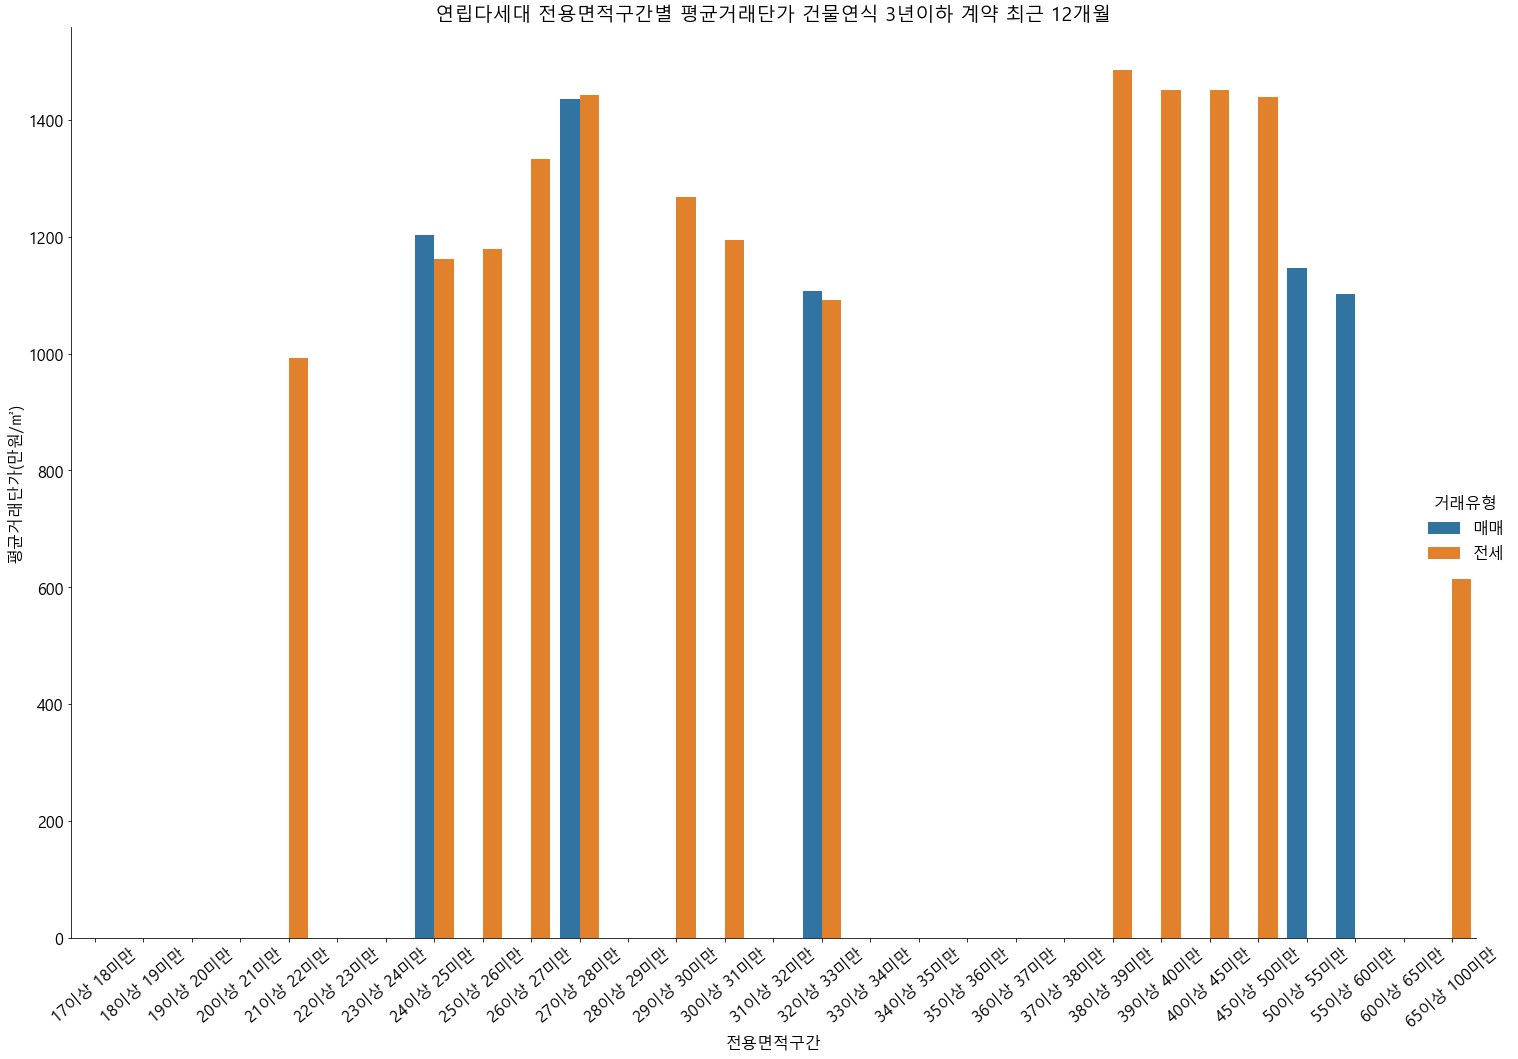

In [67]:
font = {'size': 16}
matplotlib.rc('font', **font)
sns.factorplot(x='전용면적구간', y='평균거래단가(만원/㎡)', hue='거래유형', data=concat_df, kind='bar', size=15, aspect=4/3)
plt.xticks(rotation=40)
plt.title('연립다세대 전용면적구간별 평균거래단가 건물연식 3년이하 계약 최근 12개월')
plt.tight_layout()
plt.savefig(target_dir + '전용면적구간별_연립다세대_평균거래단가_건물연식3년_계약최근12개월.png')

In [68]:
officetel_range_statistics_df = create_price_range_statistics_df(real_estate_type='오피스텔')
officetel_jeonse_range_statistics_df = create_price_range_statistics_df(tradetype='전세', real_estate_type='오피스텔')

c:\users\max6296\ml\lib\site-packages\ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


0it [00:00, ?it/s]

c:\users\max6296\ml\lib\site-packages\ipykernel_launcher.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [69]:
officetel_range_statistics_df.to_excel(target_dir + '전용면적구간별통계자료_오피스텔_매매_실거래가_건물연식{}년_계약최근12개월.xlsx'.format(3), index=False)

In [70]:
officetel_jeonse_range_statistics_df.to_excel(target_dir + '전용면적구간별통계자료_오피스텔_전세_실거래가_건물연식{}년_계약최근12개월.xlsx'.format(3), index=False)

In [71]:
officetel_range_statistics_df['거래유형'] = '매매'
officetel_jeonse_range_statistics_df['거래유형'] = '전세'

In [72]:
concat_df = pd.concat([officetel_range_statistics_df, officetel_jeonse_range_statistics_df]).sort_values(['전용면적구간', '거래유형']).reset_index(drop=True)
print(concat_df.shape)
concat_df.head()

(58, 4)


,전용면적구간,거래대상수,평균거래단가(만원/㎡),거래유형
0,17이상 18미만,0.0,NaN,매매
1,17이상 18미만,0.0,NaN,전세
2,18이상 19미만,0.0,NaN,매매
3,18이상 19미만,0.0,NaN,전세
4,19이상 20미만,0.0,NaN,매매


c:\users\max6296\ml\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
c:\users\max6296\ml\lib\site-packages\seaborn\categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


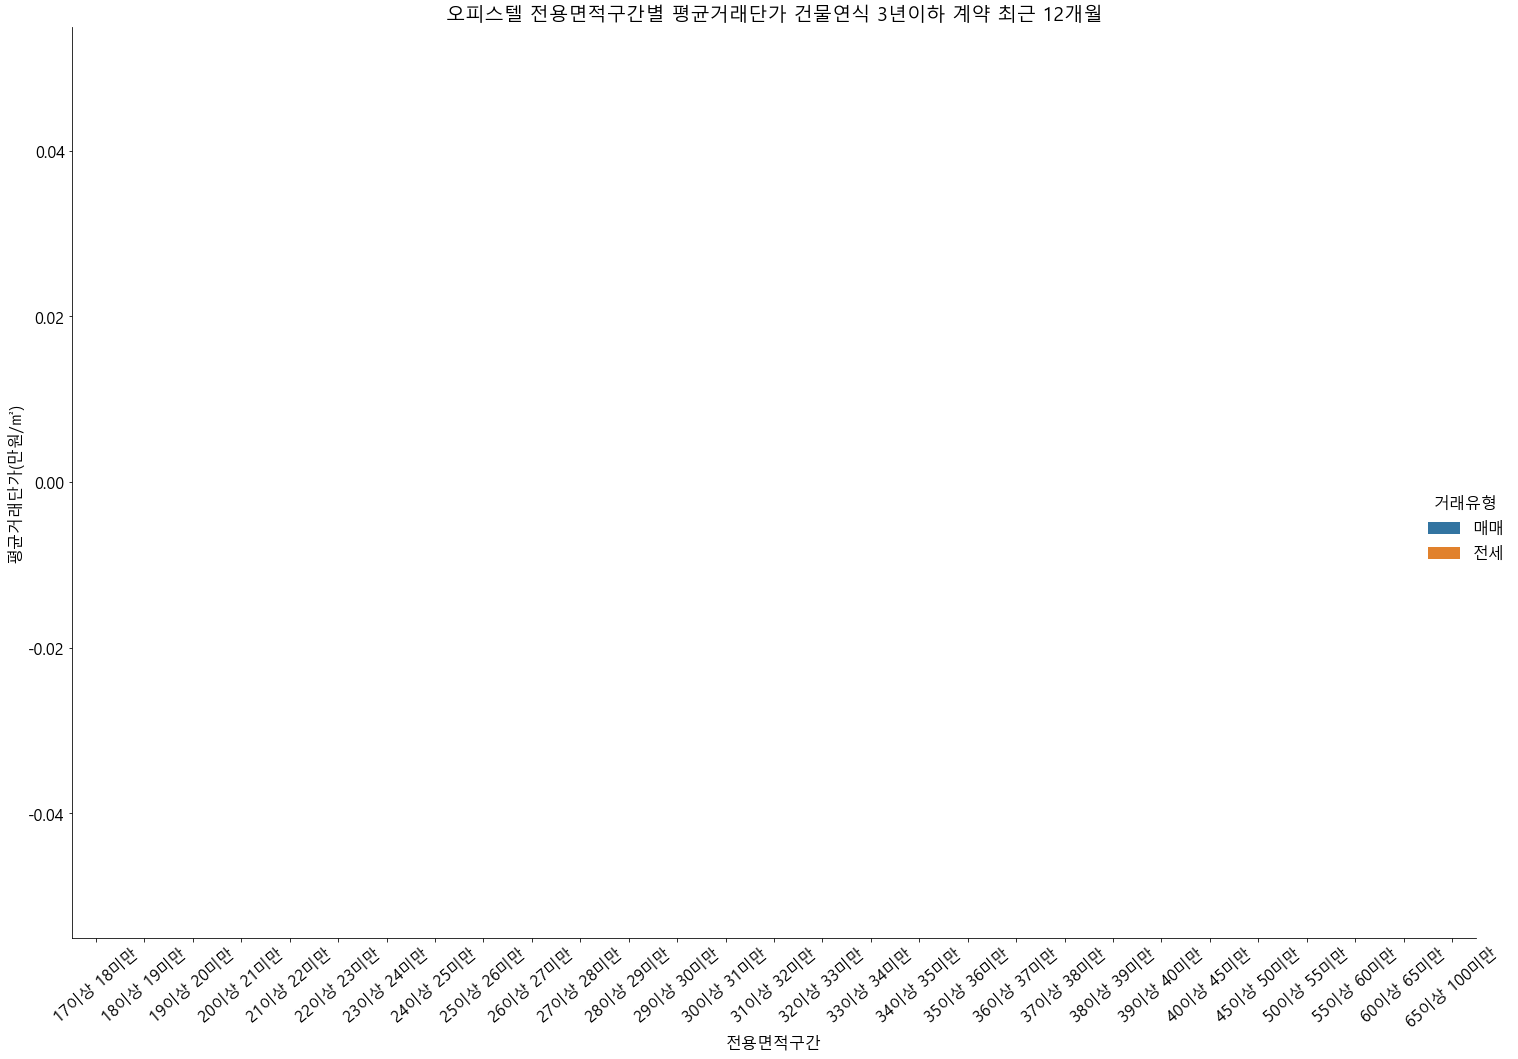

In [73]:
font = {'size': 16}
matplotlib.rc('font', **font)
sns.factorplot(x='전용면적구간', y='평균거래단가(만원/㎡)', hue='거래유형', data=concat_df, kind='bar', size=15, aspect=4/3)
plt.xticks(rotation=40)
plt.title('오피스텔 전용면적구간별 평균거래단가 건물연식 3년이하 계약 최근 12개월')
plt.tight_layout()
plt.savefig(target_dir + '전용면적구간별_오피스텔_평균거래단가_건물연식3년_계약최근12개월.png')

In [74]:
target_df = target_3_36_df.copy()

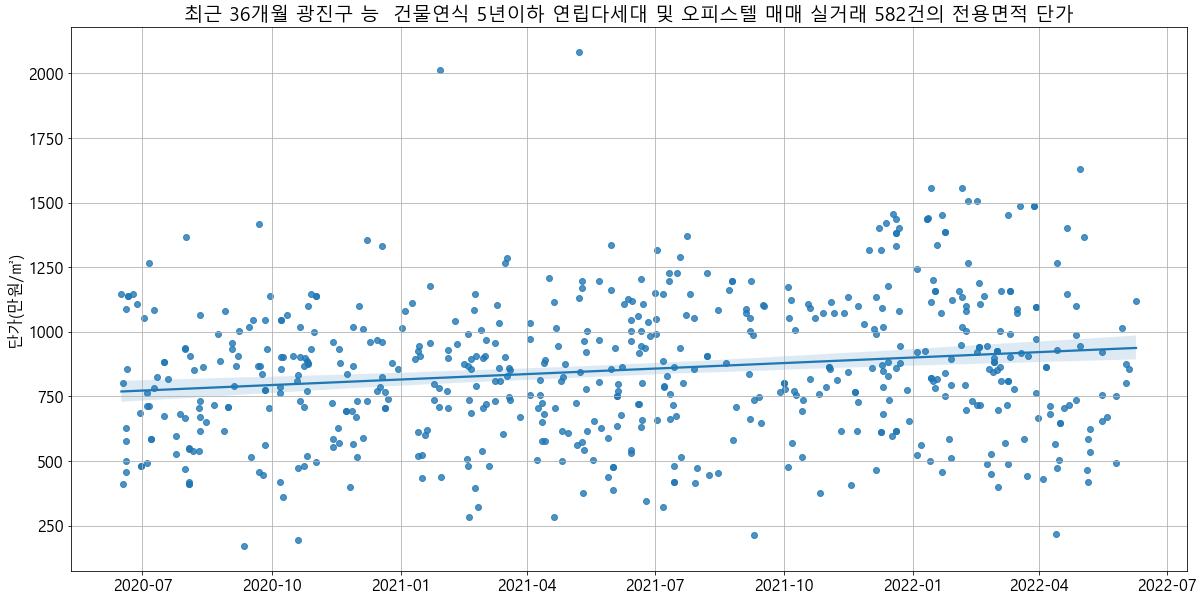

In [75]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('최근 {}개월 {} {} {} 건물연식 {}년이하 연립다세대 및 오피스텔 매매 실거래 {}건의 전용면적 단가'.format(target_period, target_gu, target_dong, target_ri, target_building_age, target_df.shape[0]))
plt.grid(True)
ax.xaxis.update_units(target_df['계약날짜'])
sns.regplot(x=ax.xaxis.convert_units(target_df['계약날짜']), y=target_df['단가(만원/㎡)'])
plt.savefig(target_dir + '산포도.png')

In [76]:
target_last_df = target_df.drop_duplicates(subset=['지번주소', '건축년도'], keep='last').reset_index(drop=True)

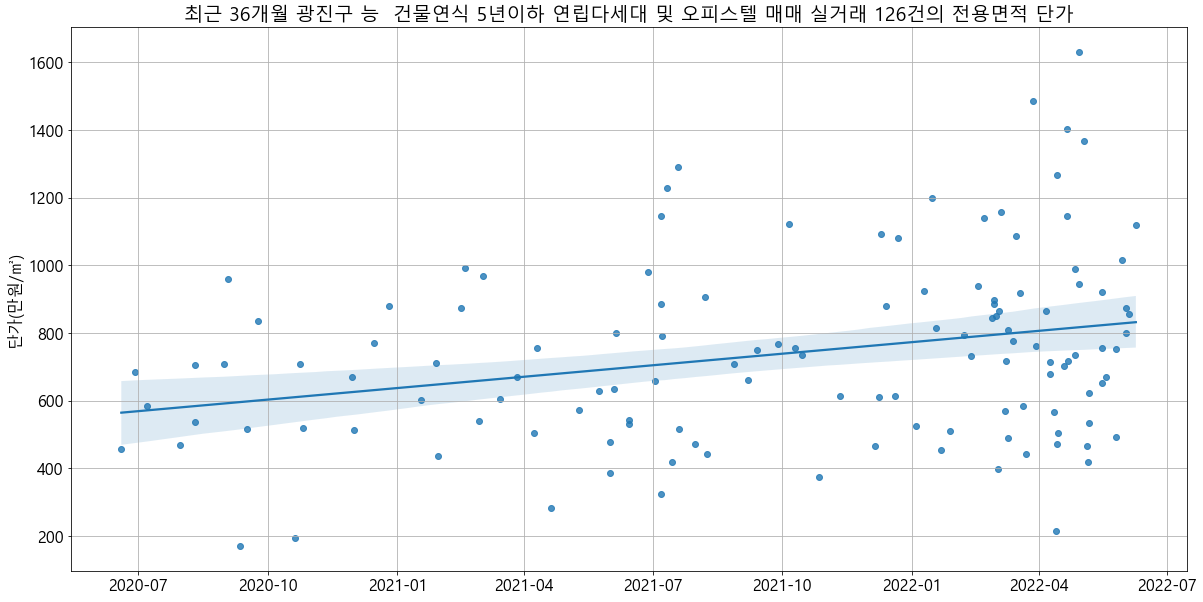

In [77]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('최근 {}개월 {} {} {} 건물연식 {}년이하 연립다세대 및 오피스텔 매매 실거래 {}건의 전용면적 단가'.format(target_period, target_gu, target_dong, target_ri, target_building_age, target_last_df.shape[0]))
plt.grid(True)
ax.xaxis.update_units(target_last_df['계약날짜'])
sns.regplot(x=ax.xaxis.convert_units(target_last_df['계약날짜']), y=target_last_df['단가(만원/㎡)'])
plt.savefig(target_dir + '마지막_산포도.png')

In [78]:
target_last_df.to_excel(target_dir + '마지막_실거래가.xlsx', index=False)

In [79]:
target_df2 = house_df[
    (house_df['지번주소'].str.contains(target_gu + ' ' + target_dong))
    &(house_df['지번주소'].str.contains(target_ri))
    #&(house_df['동'] == target_dong)
    #&(house_merge_df['계약날짜'] >= (date_today - pd.DateOffset(months=target_period)))
    &(house_df['계약날짜기준_건물연식'] <= target_building_age)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_df2.shape)
target_df2.head()

(611, 27)


,지번주소,도로명,시군구,본번,부번,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,거래유형,중개사소재지,거래구분,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,계약기간,계약구분,갱신요구권 사용,종전계약 보증금 (만원),종전계약 월세 (만원),부동산유형,구,동,리,일괄계약
327659,서울특별시 광진구 능동 135-8,능동로32길 82-27,서울특별시 광진구 능동,135.0,8.0,135-8,22.03,22000,4,2016.0,NaN,NaN,전세,4.0,2020-05-28,998.638221,6.0,NaN,NaN,NaN,NaN,NaN,연립다세대,광진구,능동,135-8,N
327660,서울특별시 광진구 능동 135-8,능동로32길 82-27,서울특별시 광진구 능동,135.0,8.0,135-8,30.15,23000,3,2016.0,NaN,NaN,전세,3.0,2019-02-11,762.852405,6.0,NaN,NaN,NaN,NaN,NaN,연립다세대,광진구,능동,135-8,N
327661,서울특별시 광진구 능동 135-8,능동로32길 82-27,서울특별시 광진구 능동,135.0,8.0,135-8,30.15,24000,3,2016.0,NaN,NaN,전세,5.0,2021-01-25,796.019900,6.0,-,-,-,NaN,NaN,연립다세대,광진구,능동,135-8,N
327663,서울특별시 광진구 능동 135-8,능동로32길 82-27,서울특별시 광진구 능동,135.0,8.0,135-8,31.68,23000,3,2016.0,NaN,NaN,전세,3.0,2019-03-18,726.010101,6.0,NaN,NaN,NaN,NaN,NaN,연립다세대,광진구,능동,135-8,N
327664,서울특별시 광진구 능동 135-8,능동로32길 82-27,서울특별시 광진구 능동,135.0,8.0,135-8,31.68,25000,2,2016.0,NaN,NaN,전세,4.0,2020-09-04,789.141414,6.0,NaN,NaN,NaN,NaN,NaN,연립다세대,광진구,능동,135-8,N


In [80]:
target_df2 = get_index_applied_prices(target_df2)

<AxesSubplot:title={'center':'광진구 능  계약날짜기준 건물연식 5년이하 연립다세대 및 오피스텔 매매 실거래 611건의 전용면적 단가'}, xlabel='단가(만원/㎡)', ylabel='Count'>

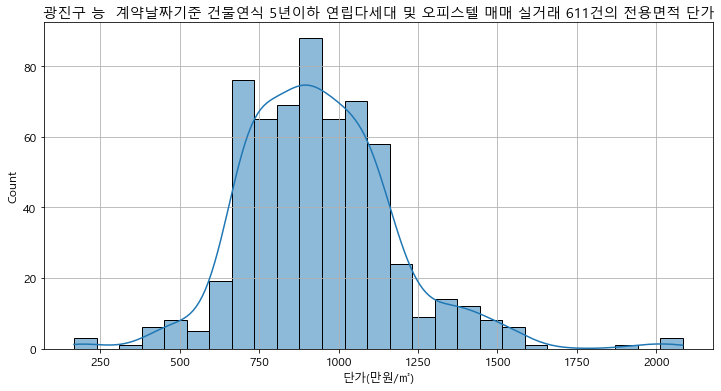

In [81]:
font = {'size': 12}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(12,6))
plt.title('{} {} {} 계약날짜기준 건물연식 {}년이하 연립다세대 및 오피스텔 매매 실거래 {}건의 전용면적 단가'.format(target_gu, target_dong, target_ri, target_building_age, target_df2.shape[0]))
plt.grid(True)
sns.histplot(target_df2['단가(만원/㎡)'], kde=True)

In [82]:
target_df3 = target_df2[['지번주소', '건물(단지)명', '건축년도', '층', '전용면적(㎡)', '계약날짜', '단가(만원/㎡)', '부동산유형']]
target_df3 = target_df3.sort_values(['지번주소', '건축년도', '계약날짜']).reset_index(drop=True)
target_df3.to_excel(target_dir + '전체_실거래가.xlsx', index=False)

In [83]:
target_df3_30 = target_df3[
    (target_df3['전용면적(㎡)'] >= 28)
    &(target_df3['전용면적(㎡)'] <= 32)
]

In [84]:
target_df3_30.to_excel(target_dir + '전체_실거래가_30.xlsx', index=False)

In [85]:
concat_df = pd.concat([target_df2])

In [86]:
concat_df = concat_df.sort_values(['지번주소', '건축년도', '전용면적(㎡)', '계약날짜']).reset_index(drop=True)
concat_df = concat_df.drop_duplicates(['지번주소', '건축년도', '전용면적(㎡)'], keep='last').reset_index(drop=True)

In [87]:
concat_df['단가평균'] = concat_df[['지번주소', '건축년도', '단가(만원/㎡)']].groupby(['지번주소', '건축년도']).transform('mean')['단가(만원/㎡)']
concat_df['지수적용단가평균'] = concat_df[['지번주소', '건축년도', '지수적용단가']].groupby(['지번주소', '건축년도']).transform('mean')['지수적용단가']

In [88]:
concat_df = concat_df.sort_values(['지번주소', '건축년도', '지수적용날짜']).reset_index(drop=True)
print(concat_df.shape)
concat_df.head()

(221, 32)


,지번주소,도로명,시군구,본번,부번,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,거래유형,중개사소재지,거래구분,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,계약기간,계약구분,갱신요구권 사용,종전계약 보증금 (만원),종전계약 월세 (만원),부동산유형,구,동,리,일괄계약,계약날짜_실거래지수,지수적용단가,지수적용날짜,단가평균,지수적용단가평균
0,서울특별시 광진구 능동 135-8,능동로32길 82-27,서울특별시 광진구 능동,135.0,8.0,135-8,22.03,22000,4,2016.0,NaN,NaN,전세,4.0,2020-05-28,998.638221,6.0,NaN,NaN,NaN,NaN,NaN,연립다세대,광진구,능동,135-8,N,111.645,1248.537048,2022년 03월,850.744626,976.813831
1,서울특별시 광진구 능동 135-8,능동로32길 82-27,서울특별시 광진구 능동,135.0,8.0,135-8,30.15,24000,3,2016.0,NaN,NaN,전세,5.0,2021-01-25,796.019900,6.0,-,-,-,NaN,NaN,연립다세대,광진구,능동,135-8,N,122.641,905.984506,2022년 03월,850.744626,976.813831
2,서울특별시 광진구 능동 135-8,능동로32길 82-27,서울특별시 광진구 능동,135.0,8.0,135-8,31.68,24000,3,2016.0,NaN,NaN,전세,5.0,2021-10-26,757.575758,6.0,-,-,-,NaN,NaN,연립다세대,광진구,능동,135-8,N,136.283,775.919938,2022년 03월,850.744626,976.813831
3,서울특별시 광진구 능동 222-2,천호대로 570,서울특별시 광진구 능동,222.0,2.0,군자 아델리제,22.98,26000,9,2019.0,NaN,NaN,전세,2.0,2021-05-08,1131.418625,3.0,-,-,-,NaN,NaN,오피스텔,광진구,능동,222-2,N,127.664,1237.050429,2022년 03월,905.652655,958.468557
4,서울특별시 광진구 능동 222-2,천호대로 570,서울특별시 광진구 능동,222.0,2.0,군자 아델리제,17.65,12000,9,2019.0,NaN,NaN,전세,3.0,2022-04-09,679.886686,3.0,-,-,-,NaN,NaN,오피스텔,광진구,능동,222-2,N,지수없음,679.886686,지수없음,905.652655,958.468557


In [89]:
concat_last_df = concat_df.drop_duplicates(subset=['지번주소', '건축년도'], keep='last')
print(concat_last_df.shape)
concat_last_df.head()

(79, 32)


,지번주소,도로명,시군구,본번,부번,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,거래유형,중개사소재지,거래구분,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,계약기간,계약구분,갱신요구권 사용,종전계약 보증금 (만원),종전계약 월세 (만원),부동산유형,구,동,리,일괄계약,계약날짜_실거래지수,지수적용단가,지수적용날짜,단가평균,지수적용단가평균
2,서울특별시 광진구 능동 135-8,능동로32길 82-27,서울특별시 광진구 능동,135.0,8.0,135-8,31.68,24000,3,2016.0,NaN,NaN,전세,5.0,2021-10-26,757.575758,6.0,-,-,-,NaN,NaN,연립다세대,광진구,능동,135-8,N,136.283,775.919938,2022년 03월,850.744626,976.813831
4,서울특별시 광진구 능동 222-2,천호대로 570,서울특별시 광진구 능동,222.0,2.0,군자 아델리제,17.65,12000,9,2019.0,NaN,NaN,전세,3.0,2022-04-09,679.886686,3.0,-,-,-,NaN,NaN,오피스텔,광진구,능동,222-2,N,지수없음,679.886686,지수없음,905.652655,958.468557
7,서울특별시 광진구 능동 222-7,,서울특별시 광진구 능동,222.0,7.0,(222-7),31.74,22000,4,2017.0,NaN,NaN,전세,4.0,2021-10-14,693.131695,5.0,202201~202401,-,-,NaN,NaN,오피스텔,광진구,능동,222-7,N,136.283,709.915407,2022년 03월,718.789436,791.523571
10,서울특별시 광진구 능동 223-19,능동로34길 11-17,서울특별시 광진구 능동,223.0,19.0,솔하우스,23.50,22000,3,2018.0,NaN,NaN,전세,2.0,2020-01-29,936.170213,4.0,NaN,NaN,NaN,NaN,NaN,연립다세대,광진구,능동,223-19,N,109.39,1194.564831,2022년 03월,1027.960272,1199.563855
12,서울특별시 광진구 능동 224-2,능동로34길 6,서울특별시 광진구 능동,224.0,2.0,푸르미르,29.92,28300,4,2017.0,NaN,NaN,전세,5.0,2022-04-30,945.855615,5.0,-,-,-,NaN,NaN,연립다세대,광진구,능동,224-2,N,지수없음,945.855615,지수없음,988.588617,999.629570


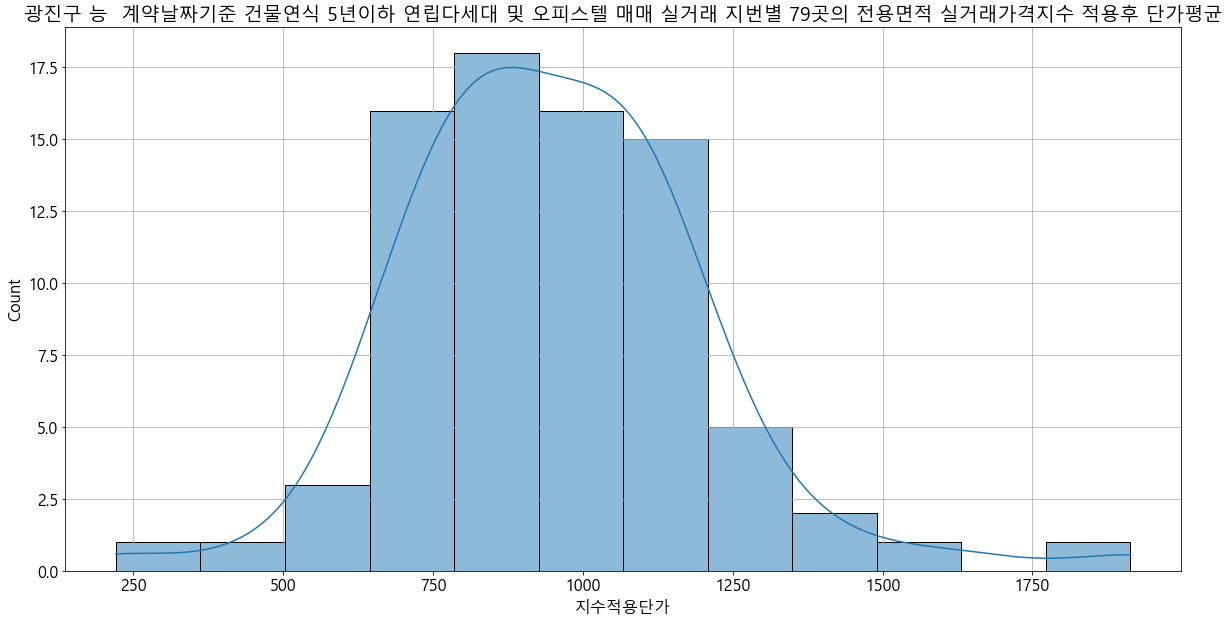

In [90]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('{} {} {} 계약날짜기준 건물연식 {}년이하 연립다세대 및 오피스텔 매매 실거래 지번별 {}곳의 전용면적 실거래가격지수 적용후 단가평균'.format(target_gu, target_dong, target_ri, target_building_age, concat_last_df.shape[0]))
plt.grid(True)
sns.histplot(concat_last_df['지수적용단가'], kde=True)
plt.savefig(target_dir + '지번별_분포도.png')

In [91]:
concat_last_df = concat_last_df.sort_values(['지번주소']).reset_index(drop=True)

In [92]:
concat_last_df = concat_last_df[['지번주소', '건물(단지)명', '건축년도', '전용면적(㎡)', '층', '계약날짜', '단가(만원/㎡)', '지수적용날짜', '지수적용단가', '부동산유형']]
concat_last_df.rename(columns={'계약날짜':'마지막_계약날짜'}, inplace=True)
concat_last_df.head()

,지번주소,건물(단지)명,건축년도,전용면적(㎡),층,마지막_계약날짜,단가(만원/㎡),지수적용날짜,지수적용단가,부동산유형
0,서울특별시 광진구 능동 135-8,135-8,2016.0,31.68,3,2021-10-26,757.575758,2022년 03월,775.919938,연립다세대
1,서울특별시 광진구 능동 222-2,군자 아델리제,2019.0,17.65,9,2022-04-09,679.886686,지수없음,679.886686,오피스텔
2,서울특별시 광진구 능동 222-7,(222-7),2017.0,31.74,4,2021-10-14,693.131695,2022년 03월,709.915407,오피스텔
3,서울특별시 광진구 능동 223-19,솔하우스,2018.0,23.50,3,2020-01-29,936.170213,2022년 03월,1194.564831,연립다세대
4,서울특별시 광진구 능동 224-2,푸르미르,2017.0,29.92,4,2022-04-30,945.855615,지수없음,945.855615,연립다세대


In [93]:
concat_last_df.to_excel(target_dir + '전체_마지막_실거래가.xlsx', index=False)